In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Display
import skimage.io as io
import cv2
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import Image, display
from PIL import Image as Img
from PIL import ImageTk
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from tensorflow.keras.models import Model, load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
def get_img_array(img_path, size):
    
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    
    return array

In [4]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = preds
        class_channel = preds

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [5]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    
    return Image(cam_path)


In [8]:
#model = load_model('/content/drive/MyDrive/Daming Colab/Ranking/Model/PTR/_rankingnet_mobilenet2050_30eMD.h5')
#model = load_model('/content/drive/MyDrive/Daming Colab/Ranking/Model/PTR/_rankingnet_Xception4098_30eMD.h5')
#model = load_model('/content/drive/MyDrive/Daming Colab/Ranking/Model/PTR/_rankingnet_VGG8194_30eMD.h5')
#model = load_model('/content/drive/MyDrive/Daming Colab/Ranking/Model/PTR/_rankingnet_ResNet4098_30eMD.h5')
model = load_model('/content/drive/MyDrive/Daming Colab/Ranking/Model/DTR/_Drankingnet_ResNet2049_30eMD.h5')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

[-5.16500998  0.        ]


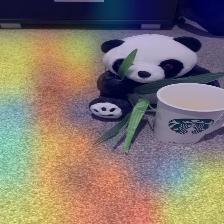

In [9]:
img_size = (224, 224)
# Make model

img_path='/content/drive/MyDrive/Daming Colab/Ranking/Frames_withcup/frame230.jpg'
img_array = preprocess_input(get_img_array(img_path, size=img_size))
#model.summary()
# Remove last layer's softmax
#model.layers[-1].activation = None
#model.layers[-2].activation = None
#model.layers[-3].activation = None
#model.layers[-4].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)[0]
preds=np.squeeze(preds)
preds=np.expand_dims(preds, axis=0)
preds=np.append(preds,0)
print(preds)
#print("Predicted:", decode_predictions(preds, top=1))

# Generate class activation heatmap
last_conv_layer_name="conv5_block3_out"



heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
# Display heatmap
#plt.matshow(heatmap)
#plt.show()
save_and_display_gradcam(img_path, heatmap)

In [ ]:
def RUN(img_path):
  img_size = (224, 224)
  img_array = preprocess_input(get_img_array(img_path, size=img_size))
  preds = model.predict(img_array)[0]
  preds=np.squeeze(preds)
  preds=np.expand_dims(preds, axis=0)
  preds=np.append(preds,0)
  last_conv_layer_name="conv_pw_12_bn"
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  # Display heatmap
  #plt.matshow(heatmap)
  #plt.show()

  img=save_and_display_gradcam(img_path, heatmap)

  return img

In [ ]:
def get_concat_h(im1, im2):


    newwidth=image1_size[0] + image2_size[0]
    dst = Img.new('RGB', (2240, im1.height),(250,250,250))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

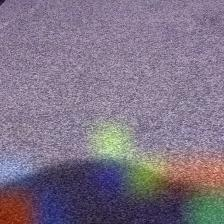

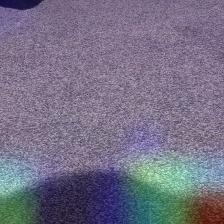

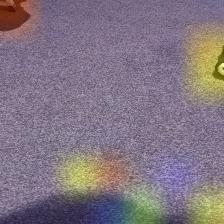

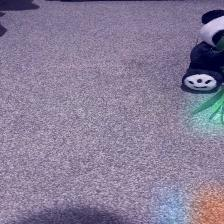

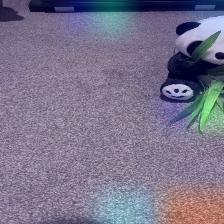

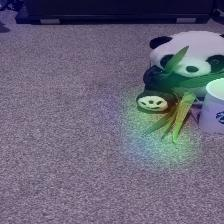

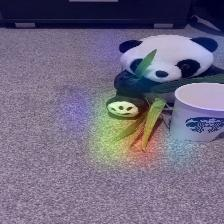

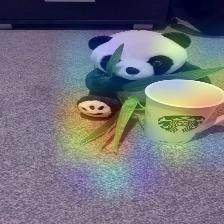

In [ ]:
#model = load_model('/content/drive/MyDrive/Daming Colab/Ranking/Model/DTR/_Drankingnet_VGG4097_30eMD.h5')
model = load_model('/content/drive/MyDrive/Daming Colab/Ranking/Model/PTR/_rankingnet_mobilenet2050_30eMD.h5')

Frames_Path='/content/drive/MyDrive/Daming Colab/Ranking/Frames_withcup/'
for files in  os.listdir(Frames_Path):
        Frames = os.listdir(Frames_Path)
        Frames_num=np.size(Frames)

n=8
index=np.linspace(1, Frames_num, n).astype(int)

for i in range(n):  

  num=str(index[i])
  num=num.zfill(3)
  path=Frames_Path+'frame'+num+'.jpg'

  img=RUN(path)

  display(img)

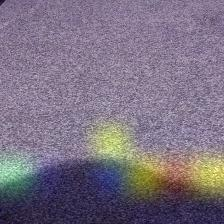

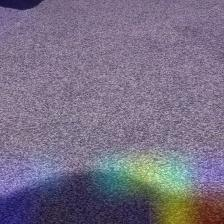

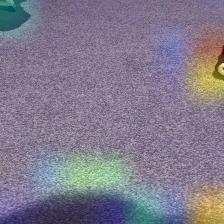

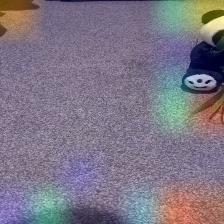

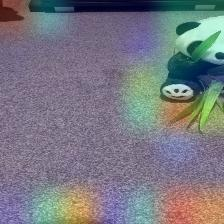

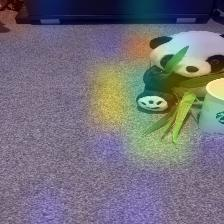

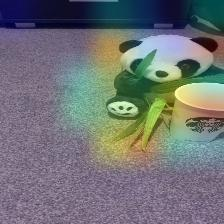

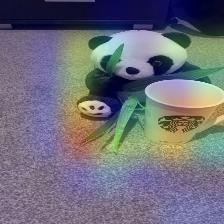

In [ ]:
model = load_model('/content/drive/MyDrive/Daming Colab/Ranking/Model/DTR/_Drankingnet_mobilenet1025_0.01dp30eMD.h5')
#model = load_model('/content/drive/MyDrive/Daming Colab/Ranking/Model/PTR/_rankingnet_VGG8194_30eMD.h5')

Frames_Path='/content/drive/MyDrive/Daming Colab/Ranking/Frames_withcup/'
for files in  os.listdir(Frames_Path):
        Frames = os.listdir(Frames_Path)
        Frames_num=np.size(Frames)

n=8
index=np.linspace(1, Frames_num, n).astype(int)

for i in range(n):  

  num=str(index[i])
  num=num.zfill(3)
  path=Frames_Path+'frame'+num+'.jpg'

  img=RUN(path)

  display(img)